In [71]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
from pydensecrf import densecrf
from pydensecrf.utils import create_pairwise_bilateral, unary_from_softmax
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms import InterpolationMode

In [72]:
palette = {
    0:  (0, 0, 0, 0),         # Black
    1:  (255, 0, 0, 153),       # Red
    2:  (0, 255, 0, 153),       # Green
    3:  (0, 0, 255, 153),       # Blue
    4:  (255, 255, 0, 153),     # Yellow
    5:  (0, 255, 255, 153),     # Cyan
    6:  (255, 0, 255, 153),     # Magenta
    7:  (128, 0, 0, 153),       # Maroon
    8:  (0, 128, 0, 153),       # Dark green
    9:  (0, 0, 128, 153),       # Navy
    10: (128, 128, 0, 153),     # Olive
    11: (0, 128, 128, 153),     # Teal
    12: (192, 192, 192, 153),   # Silver
    13: (128, 128, 128, 153),   # Gray
    14: (0, 192, 192, 153),     # Turquoise
    15: (192, 0, 192, 153),     # Fuchsia
    16: (192, 64, 0, 153),      # Red-orange
    17: (192, 192, 0, 153),     # Gold
    18: (0, 64, 128, 153),      # Darker navy
    19: (64, 128, 64, 153),     # Mid-green
    20: (192, 128, 64, 153),    # Tan
    255: (255, 255, 255, 0),  # White
}

classes = ['background','aeroplane','bicycle','bird', 'boat','bottle','bus','car','cat','chair',
           'cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep',
           'sofa','train','tvmonitor', 'ambiguous']

def apply_palette(image, palette):
    # Create an empty RGB image with the same height and width as the input
    rgb_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            class_index = image[i, j]
            rgb_values = palette[class_index]
            rgb_image[i, j, :] = rgb_values

    return rgb_image

In [73]:
def crf_postprocess(probs, img, n_labels):

  _, h, w = probs.shape

  # The input should be negative log probabilities
  unary = unary_from_softmax(probs)

  # The inputs should be C-continious
  unary = np.ascontiguousarray(unary)

  d = densecrf.DenseCRF2D(w, h, n_labels)
  d.setUnaryEnergy(unary)

  # Potential penalties for edge-preserving appearance
  # You can adjust these parameters as needed
  d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=densecrf.DIAG_KERNEL, normalization=densecrf.NORMALIZE_SYMMETRIC)
  d.addPairwiseBilateral(sxy=(30, 30), srgb=(0.5,0.5,0.5), rgbim=img, compat=10, kernel=densecrf.DIAG_KERNEL, normalization=densecrf.NORMALIZE_SYMMETRIC)

  # Inference
  q = d.inference(5)  # You can adjust the number of iterations
  predictions = np.argmax(q, axis=0).reshape((h, w))

  return predictions

In [74]:
model = fcn_resnet50(weights=None, weights_backbone=ResNet50_Weights.IMAGENET1K_V1, num_classes=21)

model.load_state_dict(torch.load("/home/youxiang/Desktop/FYP/WSSS_method/best_model/weak_CE.pth"))

model.to("cuda")
model.eval()


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [75]:
img_path = "/home/youxiang/Desktop/FYP/WSSS_method/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2011_002975.jpg"
input_image = Image.open(img_path).convert("RGB")
img2pass = input_image.resize([256, 256], Image.BILINEAR)
img2pass_np = np.array(img2pass)

"""
2007_009245
2008_002240
2008_003885
2008_003886
2008_003976
2008_006722
2010_004556
2011_001665
2011_001713
2011_001812
2011_002975
"""

preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).unsqueeze(0).to("cuda")

In [76]:
with torch.no_grad():
    output = model(input_tensor)["out"]

print(output.shape)

probabilities = F.softmax(output, dim=1)

print(probabilities.shape)

probabilities_np = probabilities.detach().cpu().numpy()
probabilities_np = probabilities_np.squeeze(0)
print(probabilities_np.shape)


refined_predictions = crf_postprocess(probabilities_np, img2pass_np, 21)
pred_paletted = apply_palette(refined_predictions, palette)

torch.Size([1, 21, 256, 256])
torch.Size([1, 21, 256, 256])
(21, 256, 256)


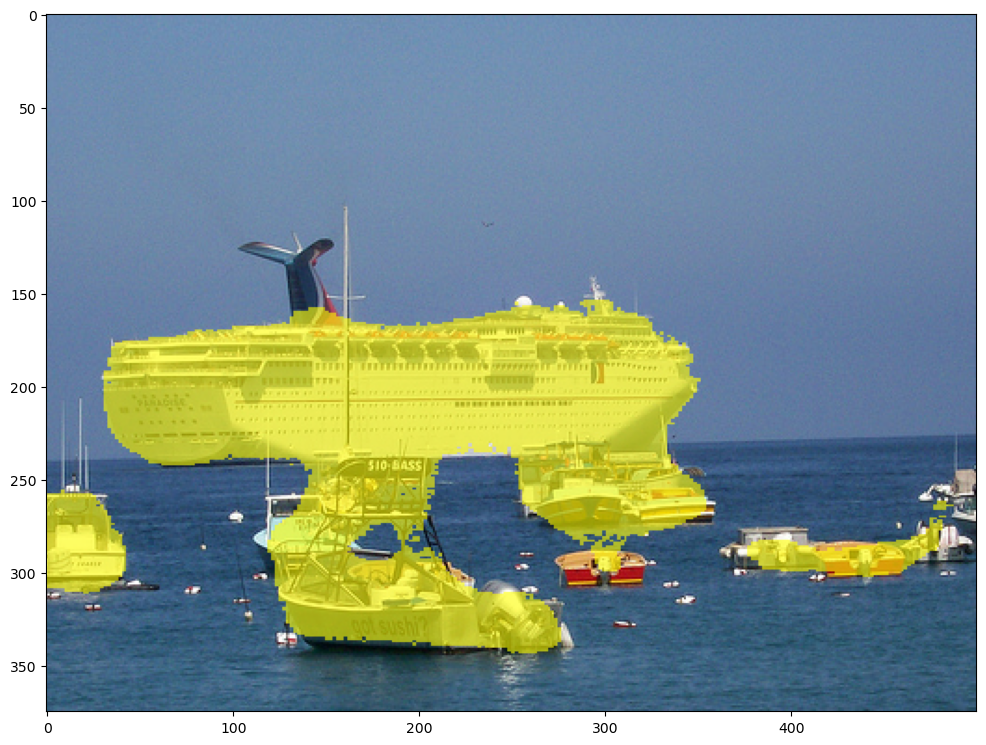

In [77]:
pred_mask = Image.fromarray(pred_paletted.astype(np.uint8))
mask_resized = pred_mask.resize(input_image.size, Image.NEAREST)
input_image.paste(mask_resized, (0, 0), mask_resized)
plt.figure(figsize=[12, 12])
plt.imshow(input_image)